# Getting started with tomsup

Tomsup, Theory of Mind Simulation using Python, is a Python Package for Agent Based simulations. It includes 1) a framework for running agent based simulations using 2 by 2 payoffmatrices and most notably 2) an implementation of game theory of mind in a agent based framework following the implementation of [Devaine, et al. (2017)](http://dx.plos.org/10.1371/journal.pcbi.1005833).

This tutorial will simply introduce the framework of tomsup, for an introduction to the theory of mind (ToM) agent, see *introduction_to_tom.ipynb*.

It is also possible for create your own agents for an introduction on this see *creating_an_agent.ipynb*. 

Lastly we have also created an brief introduction to each of the simpler agents for this see *introduction_to_basic_agents.ipynb*.


In [1]:
#assuming you are in the github folder change the path - not relevant if tomsup is installed via. pip
import os
print(os.getcwd())
os.chdir("..") # go out of the tutorials folder

/Users/au561649/Desktop/Github/tomsup/python package/tutorials


In [2]:
import tomsup as ts

To get an overview of possible agent you can use the following function. Give you a brief description of their strategy as well as a reference for further reading.

In [3]:
ts.valid_agents()

{'RB': {'name': 'Random Bias',
  'shorthand': 'RB',
  'example': 'RB(bias = 0.7)',
  'reference': 'Devaine, et al. (2017)',
  'strategy': 'Chooses 1 randomly based on a probability or bias'},
 'WSLS': {'name': 'Win-stay, lose-switch',
  'shorthand': 'WSLS',
  'example': 'WSLS()',
  'reference': 'Nowak & Sigmund (1993)',
  'strategy': 'If it win it chooses the same option again, if it lose it change to another'},
 'TFT': {'name': 'Tit-for-Tat',
  'shorthand': 'TFT',
  'example': 'TFT()',
  'reference': 'Shelling (1981)',
  'strategy': 'Intended the prisoners dilemma. It starts out cooperating and then simply copies it opponents action.'},
 'QL': {'name': 'Q-Learning Model',
  'shorthand': 'QL',
  'example': 'QL(learning_rate = 0.5, b_temp = 1)',
  'reference': 'Watkinns (1992)',
  'strategy': 'A simple reinforcement learning model, which is more choose e.g. 1 if 1 have previously been shown to yield positive result.'},
 'TOM': {'name': 'Theory of Mind',
  'shorthand': 'TOM',
  'example'

---
## 1) Creating an agent
First we will set up a Random bias (RB) agent. This agent simply choses randomly with a given bias.
There is two ways to setup an agent, either using the agent class (e.g. RB) or using the ```create_agents()``` function. We will start by calling the agent class RB directy. For a whole list of valid agent use the ```ts.valid_agents()```.

In [4]:
jung = ts.RB(bias = 0.7, save_history = True) #calling the agent subclass RB - for more on save_history see '3) inspecting Agent and AgentGroup'

# Let's examine the jung
print(f"jung is an class of type: {type(jung)}")
if isinstance(jung, ts.Agent):
    print(f"but jung is also an instance of the parent class ts.Agent")

# let us have Jung make a choice 
choice = jung.compete()

print(f"jung chose {choice} and his probability for choosing 1 was {jung.get_bias()}.")

jung is an class of type: <class 'tomsup.agent.RB'>
but jung is also an instance of the parent class ts.Agent
jung chose 0 and his probability for choosing 1 was 0.7.


As previously mentioned you can also create agents using the `create_agent` function. Here we will create skinner as a Q-learning agent, which is a simple reinforcement learning agent, see Watkinns (1992) for more.

In [5]:
skinner = ts.create_agents(agents = "QL", start_params = {'save_history': True}) # create a reinforcement learning agent

Since skinner is a reinforcement learning agent his compete function requires him to know which game he is playing, so he can choose based on payoff. He also needs to know his opponents move during their last turn, so that he can update his belief about his opponent choices.

Let us have jung and skinner play the the matching pennies game. We can fetch the game from the function `PayoffMatrix`,

In [6]:
penny = ts.PayoffMatrix(name = "penny_competitive") # fetch the competitive matching pennies game.

#print the payoff matrix
print(penny)

#fetch the underlying numpy matrix
print(penny.get_matrix())

<Class PayoffMatrix, Name = penny_competitive> 
The payoff matrix of agent 0
       |  Choice agent 1
       |    |  0 |  1 |
       | ------------ |
Choice |  0 |  1 | -1 |
agent 0|  1 | -1 |  1 |
 
The payoff matrix of agent 1
       |  Choice agent 1
       |    |  0 |  1 |
       | ------------ |
Choice |  0 | -1 |  1 |
agent 0|  1 |  1 | -1 |
 
[[[ 1 -1]
  [-1  1]]

 [[-1  1]
  [ 1 -1]]]


Let us try to have skinner and jung compete in the matching pennies game:

In [7]:
jung_a = jung.compete() # a for action
skinner_a = skinner.compete(p_matrix = penny, agent = 1, op_choice = None) #Note that op_choice can be unspecified (or None) in the first round

jung_p = penny.payoff(action_agent0 = jung_a, action_agent1 = skinner_a, agent = 0)
skinner_p = penny.payoff(action_agent0 = jung_a, action_agent1 = skinner_a, agent = 1)

print(f"jung chose {jung_a} and skinner chose {skinner_a}, which results in a payoff for jung of {jung_p} and skinner of {skinner_p}.")
# Note that you might get different results simply by chance

jung chose 1 and skinner chose 1, which results in a payoff for jung of 1 and skinner of -1.


---
## 2) Running a tournament
In the above case we saw how to have two agents compete for a single round. It is however rare that we only need 1 round and while the above functionality can be wrapped within a for we have made a `compete()` function for convenience. In this section we will also examine the class `AgentGroup`, which allows you to run tournaments with multiple agents.

Let us start with having the two agent compete for 30 rounds in the matching pennies game:

In [8]:
results = ts.compete(jung, skinner, p_matrix=penny, n_rounds = 30, save_history=True)
print(type(results))

jung_sum = results['payoff_agent0'].sum()
skinner_sum = results['payoff_agent1'].sum()

print(f"jung seemed to get a total of {jung_sum} points, while skinner got a total of {skinner_sum}.")

results.head() #inspect the first 5 rows of the df

<class 'tomsup.plot.ResultsDf'>
jung seemed to get a total of -10 points, while skinner got a total of 10.


,round,choice_agent0,choice_agent1,payoff_agent0,payoff_agent1,history_agent0,history_agent1
0,0,1,0,-1,1,{'choice': 1},"{'choice': 0, 'expected_value0': 0.5, 'expecte..."
1,1,1,0,-1,1,{'choice': 1},"{'choice': 0.0, 'expected_value0': 0.5, 'expec..."
2,2,1,1,1,-1,{'choice': 1},"{'choice': 1.0, 'expected_value0': 0.5, 'expec..."
3,3,0,0,1,-1,{'choice': 0},"{'choice': 0.0, 'expected_value0': 0.5, 'expec..."
4,4,0,0,1,-1,{'choice': 0},"{'choice': 0.0, 'expected_value0': 0.5, 'expec..."


We see that the output of the compete function if a pandas dataframe. It is possible to change this to a list by specifying `return_val = "list"`, but having it as a dataframe allow for convenient operators attributes such as mean() and sum().

The above case a the simplest possible version of the `compete()` function. You can also specify number of simulations, whether the agent should be reset after each simulation (this is recommended) and whether it should print what simulation it is running (`silent`).




In [9]:
results = ts.compete(jung, skinner, penny, n_rounds=30, n_sim=3, save_history=True, return_val='df', silent=False)
results.head()

Running simulation 1 out of 3
	Running simulation 2 out of 3
	Running simulation 3 out of 3


,n_sim,round,choice_agent0,choice_agent1,payoff_agent0,payoff_agent1,history_agent0,history_agent1
0,0,0,1,0,-1,1,{'choice': 1},"{'choice': 0, 'expected_value0': 0.5, 'expecte..."
1,0,1,1,0,-1,1,{'choice': 1},"{'choice': 0.0, 'expected_value0': 0.5, 'expec..."
2,0,2,1,0,-1,1,{'choice': 1},"{'choice': 0.0, 'expected_value0': 0.5, 'expec..."
3,0,3,1,0,-1,1,{'choice': 1},"{'choice': 0.0, 'expected_value0': 0.5, 'expec..."
4,0,4,1,0,-1,1,{'choice': 1},"{'choice': 0.0, 'expected_value0': 0.5, 'expec..."


**Note** that by adding simulations the dataframe now also have a column called 'n_sim', for which simulations in which the results belongs.

### AgentGroup
Now as promised, let us take a look at tournaments with multiple agents. We will start of by creating a group of agents using a list of the desired agents as well as a list of their starting parameters. If you are in doubt how to specify these you can always the starting parameters from an existing agent using `jung.get_start_params()`.

In [10]:
agents = ['RB', 'QL', 'WSLS'] # create a list of agents
start_params = [{'bias': 0.7}, {'learning_rate': 0.5}, {}] # create a list of their starting parameters (an empty dictionary {} simply assumes defaults)

group = ts.create_agents(agents, start_params) # create a group of agents
print(group)
print("\n----\n") # to space out the outputs

group.set_env(env = 'round_robin') # round_robin e.g. each agent will play against all other agents

# make them compete
group.compete(p_matrix = penny, n_rounds = 20, n_sim = 4)
results = group.get_results()
results.head() #examine the first 5 rows in results

<Class AgentGroup, envinment = None> 

RB	 | 	{'bias': 0.7}
QL	 | 	{'learning_rate': 0.5}
WSLS	 | 	{}

----

Currently the pair, ('RB', 'QL'), is competing for 4                         simulations, each containg 20 rounds.
	Running simulation 1 out of 4
	Running simulation 2 out of 4
	Running simulation 3 out of 4
	Running simulation 4 out of 4
Currently the pair, ('RB', 'WSLS'), is competing for 4                         simulations, each containg 20 rounds.
	Running simulation 1 out of 4
	Running simulation 2 out of 4
	Running simulation 3 out of 4
	Running simulation 4 out of 4
Currently the pair, ('QL', 'WSLS'), is competing for 4                         simulations, each containg 20 rounds.
	Running simulation 1 out of 4
	Running simulation 2 out of 4
	Running simulation 3 out of 4
	Running simulation 4 out of 4
Simulation complete


,n_sim,round,choice_agent0,choice_agent1,payoff_agent0,payoff_agent1,agent0,agent1
0,0,0,1,0,-1,1,RB,QL
1,0,1,1,0,-1,1,RB,QL
2,0,2,1,0,-1,1,RB,QL
3,0,3,1,0,-1,1,RB,QL
4,0,4,1,0,-1,1,RB,QL


As you can see once the group is created and environment it is easy to have the agent compete with one another.

(for more possible environment, see `help(group.set_env)`)

---
## 3) Inspecting Agent and AgentGroup
So let's examine some of the attributes of the agents, which applies to all agents. In this section we will also look a bit into how to extract an agent from an agentGroup and how to examine the enviroment.

In [11]:
# What if I want to know the starting parameters?
print("This is the starting parameters of jung: ",    jung.get_start_params()) # Note that it also prints out default parameters
print("This is the starting parameters of skinner: ", skinner.get_start_params())

# What if I want to know the agent last choice?
print("This is jung's last choice: ",    jung.get_choice())
print("This is skinner's last choice: ", skinner.get_choice())

# What if I want to know the agents strategy?
print("jung's strategy is: ", jung.get_strategy())
print("skinner's strategy is: ", skinner.get_strategy())

This is the starting parameters of jung:  {'bias': 0.7, 'save_history': True}
This is the starting parameters of skinner:  {'learning_rate': 0.5, 'b_temp': 0.01, 'expec_val': [0.5, 0.25], 'save_history': True}
This is jung's last choice:  1
This is skinner's last choice:  0
jung's strategy is:  RB
skinner's strategy is:  QL


We can also get the history, recall that we specified `get_history = True` for skinner (and jung). This means we can go back and see all his previous state for the Random bias (RB) this only include the choice. This is by default returned as a dataframe. Note that by default `save_history` is `False` to save memory.

In [12]:
# What is the history of skinner (e.g. what is his choices and internal states)

history = jung.get_history(format = "df")
print(history.head())

print("\n --- \n") # for spacing

history = skinner.get_history(format = "df")
print(history.head(15)) # the first 15 rows

choice
0       0
1       1
2       1
3       1
4       1

 --- 

    choice  expected_value0  expected_value1
0      0.0              0.5             0.25
1      0.0              0.5             0.25
2      0.0              0.5             0.25
3      0.0              0.5             0.25
4      0.0              0.5             0.25
5      0.0              0.5             0.25
6      0.0              0.5             0.25
7      0.0              0.5             0.25
8      0.0              0.5             0.25
9      0.0              0.5             0.25
10     0.0              0.5             0.25
11     0.0              0.5             0.25
12     0.0              0.5             0.25
13     0.0              0.5             0.25
14     0.0              0.5             0.25


In the above we can see the history of the two agents, both their internal states, which is none for the the random bias agent (RB) and includes two for the reinforcement learning agent (QL). The two for for the RL indicates the expected value of choosing 0 rather than 1. As expected we here see that the expected value of choosing 0 increases due to the jungs bias of 0.7.

**Note** that if the agent are competing using multiple simulations it will resets the agent after each simulations, consequently their history is also reset.

# 4) Plotting results
This section provides a few quick plotting options. These are meant to be quick and easy to use and should be considered sanity checks rather that. Let's start of by creating a plot of the score the Random bias agent over time.


<Figure size 432x288 with 0 Axes>

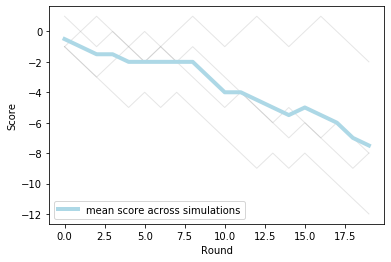

In [13]:
%matplotlib inline

ts.plot.score(results, agent0 = "RB", agent1 = "QL", agent = 0)
# agent0 and agent1 indicate the agent pair which we want to plot
# agent = 0 indicate that the want to plot the performance of the agent0 (i.e. the RB agent)

Note that the grey lines indicate the score at each simulation, this should give you an indicatation of the uncertainty in the data. From this plot we see that the Random bias agent with a bias of 0.7 (as specified earlier) tend to loose against a reinformance learning agent (QL). This is a quite reasonable result.

We can also plot the agent actions over time using ```ts.plot.choice()```. This plot indicated the action of the agent over time. This function allows of the detect a change in preference. E.g. it would allow us to model periods of collaboration in a prisonners dilemma. In this specific case however it only really show is that the Random bias agent is biases towards 1. This is natural as it bias was 0.7, indicating that it will chose 1 70% of the time.

<Figure size 432x288 with 0 Axes>

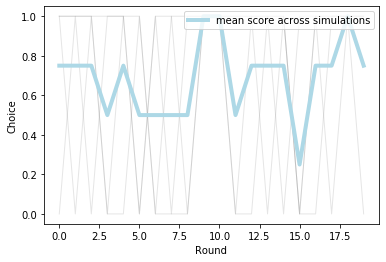

In [14]:
ts.plot.choice(results, agent0 = "RB", agent1 = "QL", agent = 0)

In [15]:
# Create a list of agents
agents = ['RB', 'QL', 'WSLS', '1-TOM', '2-TOM']
# And set their starting parameters. An empty dict denotes default values
start_params = [{'bias': 0.7}, {'learning_rate': 0.5}, {}, {}, {}] 

group = ts.create_agents(agents, start_params) # create a group of agents

# Specify the environment
# round_robin e.g. each agent will play against all other agents
group.set_env(env='round_robin') 

# Finally, we make the group compete 20 simulations of 30 rounds
group.compete(p_matrix=penny, n_rounds=30, n_sim=20, save_history=True)

Currently the pair, ('RB', 'QL'), is competing for 20                         simulations, each containg 30 rounds.
	Running simulation 1 out of 20
	Running simulation 2 out of 20
	Running simulation 3 out of 20
	Running simulation 4 out of 20
	Running simulation 5 out of 20
	Running simulation 6 out of 20
	Running simulation 7 out of 20
	Running simulation 8 out of 20
	Running simulation 9 out of 20
	Running simulation 10 out of 20
	Running simulation 11 out of 20
	Running simulation 12 out of 20
	Running simulation 13 out of 20
	Running simulation 14 out of 20
	Running simulation 15 out of 20
	Running simulation 16 out of 20
	Running simulation 17 out of 20
	Running simulation 18 out of 20
	Running simulation 19 out of 20
	Running simulation 20 out of 20
Currently the pair, ('RB', 'WSLS'), is competing for 20                         simulations, each containg 30 rounds.
	Running simulation 1 out of 20
	Running simulation 2 out of 20
	Running simulation 3 out of 20
	Running simulation

In [16]:
res = group.get_results()
res.head(1) # print the first row


,n_sim,round,choice_agent0,choice_agent1,payoff_agent0,payoff_agent1,history_agent0,history_agent1,agent0,agent1
0,0,0,1,0,-1,1,{'choice': 1},"{'choice': 0, 'expected_value0': 0.5, 'expecte...",RB,QL


In [17]:
res.loc[res["agent1"] == "2-TOM"]

,n_sim,round,choice_agent0,choice_agent1,payoff_agent0,payoff_agent1,history_agent0,history_agent1,agent0,agent1
0,0,0,1,0,-1,1,{'choice': 1},"{'choice': 0, 'internal_states': {'opponent_st...",RB,2-TOM
1,0,1,0,1,-1,1,{'choice': 0},"{'choice': 1, 'internal_states': {'opponent_st...",RB,2-TOM
2,0,2,1,0,-1,1,{'choice': 1},"{'choice': 0, 'internal_states': {'opponent_st...",RB,2-TOM
3,0,3,1,1,1,-1,{'choice': 1},"{'choice': 1, 'internal_states': {'opponent_st...",RB,2-TOM
4,0,4,1,0,-1,1,{'choice': 1},"{'choice': 0, 'internal_states': {'opponent_st...",RB,2-TOM
...,...,...,...,...,...,...,...,...,...,...
595,19,25,0,1,-1,1,"{'choice': 0, 'internal_states': {'opponent_st...","{'choice': 1, 'internal_states': {'opponent_st...",1-TOM,2-TOM
596,19,26,1,1,1,-1,"{'choice': 1, 'internal_states': {'opponent_st...","{'choice': 1, 'internal_states': {'opponent_st...",1-TOM,2-TOM
597,19,27,0,1,-1,1,"{'choice': 0, 'internal_states': {'opponent_st...","{'choice': 1, 'internal_states': {'opponent_st...",1-TOM,2-TOM
598,19,28,0,0,1,-1,"{'choice': 0, 'internal_states': {'opponent_st...","{'choice': 0, 'internal_states': {'opponent_st...",1-TOM,2-TOM


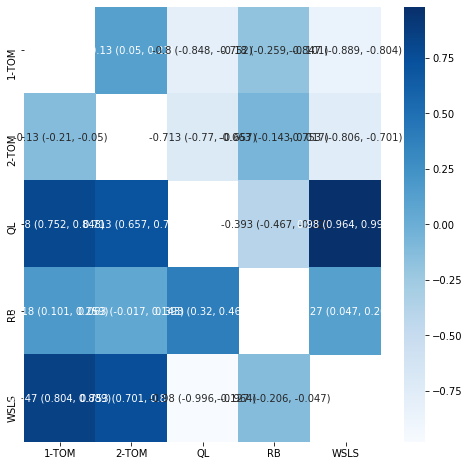

In [18]:
import matplotlib.pyplot as plt

# Set figure size
plt.rcParams["figure.figsize"] = [8,8]

group.plot_heatmap()


<Figure size 576x576 with 0 Axes>

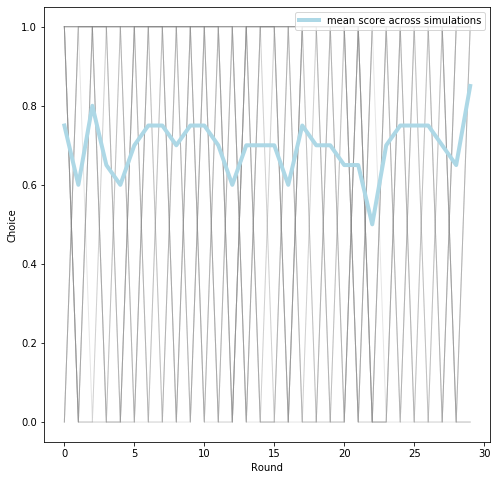

In [19]:
group.plot_choice(agent0 = "RB", agent1 = "QL", agent = 0)

<Figure size 576x576 with 0 Axes>

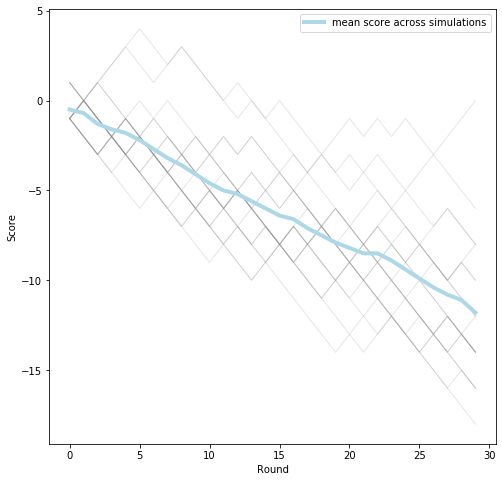

In [20]:
group.plot_score(agent0 = "RB", agent1 = "QL", agent = 0)

history_agent1 1


<Figure size 576x576 with 0 Axes>

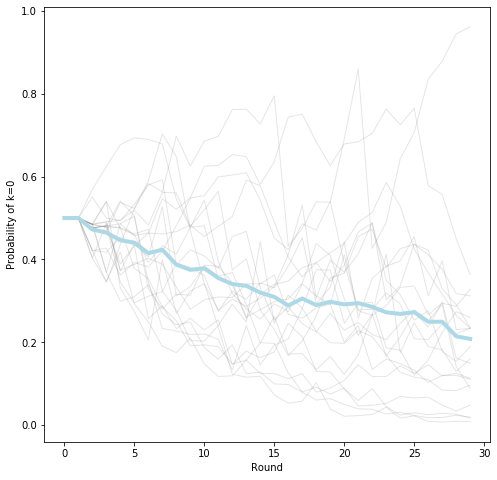

history_agent1 1


<Figure size 576x576 with 0 Axes>

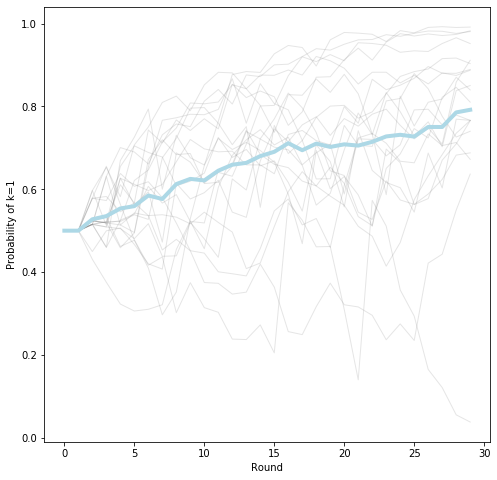

In [21]:
group.plot_p_k(agent0 = "1-TOM", agent1 = "2-TOM", agent = 1, k=0)
group.plot_p_k(agent0 = "1-TOM", agent1 = "2-TOM", agent = 1, k=1)

history_agent1 1


<Figure size 576x576 with 0 Axes>

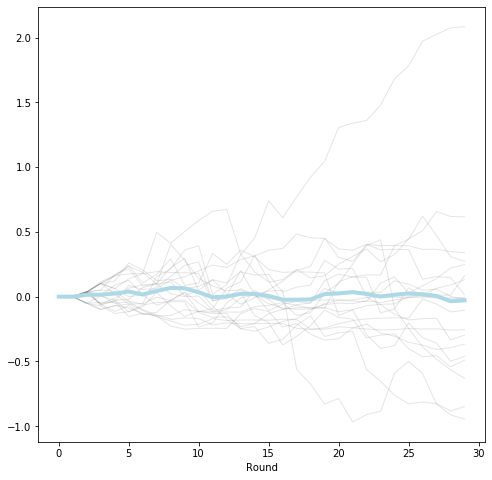

In [22]:
group.plot_history("1-TOM", "2-TOM", agent=1, state="", fun=lambda x: x['internal_states']['own_states']['param_mean'][0, 0])

In [23]:
# group.plot_op_states(agent0="1-TOM", agent1="2-TOM", state="p_op", level=0, agent=1)

In [24]:
test = ts.TOM(level=2)
test.compete(penny, agent=0)
test.compete(penny, agent=0, op_choice=1)
test.compete(penny, agent=0, op_choice=1)
test.get_level()


2

In [25]:
test = ts.TOM(level=2)
test.internal

{'opponent_states': {0: {'opponent_states': {},
   'own_states': {'p_op_mean0': 0,
    'p_op_var0': 0,
    'p_self': nan,
    'p_op': nan}},
  1: {'opponent_states': {0: {'opponent_states': {},
     'own_states': {'p_op_mean0': 0,
      'p_op_var0': 0,
      'p_self': nan,
      'p_op': nan}}},
   'own_states': {'p_k': array([1.]),
    'p_op_mean': array([0]),
    'param_mean': array([[0., 0., 0.]]),
    'param_var': array([[0., 0., 0.]]),
    'gradient': array([[0., 0., 1.]]),
    'p_self': nan,
    'p_op': nan}}},
 'own_states': {'p_k': array([0.5, 0.5]),
  'p_op_mean': array([0, 0]),
  'param_mean': array([[0., 0., 0.],
         [0., 0., 0.]]),
  'param_var': array([[0., 0., 0.],
         [0., 0., 0.]]),
  'gradient': array([[0., 0., 1.],
         [0., 0., 1.]]),
  'p_self': nan,
  'p_op': nan}}

In [26]:
# group.plot_op_states(agent0="1-TOM", agent1="2-TOM", state="p_op_mean", level=1, agent=1)

In [27]:
df = group.get_results()
df.loc[(df["agent0"] == "1-TOM") & (df["agent1"] == "2-TOM")]["history_agent1"][1]['internal_states']['opponent_states'][1]['own_states']

{'p_k': array([1.]),
 'p_op_mean': array([-0.93468267]),
 'param_mean': array([[ 0. ,  0. , -0.4]]),
 'param_var': array([[ 0.69314718,  0.        , -0.22314355]]),
 'gradient': array([[-0.14210958,  0.53465593,  1.        ]])}

history_agent1 1


<Figure size 576x576 with 0 Axes>

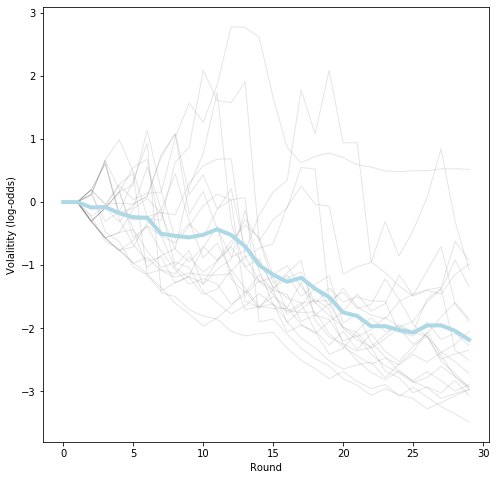

history_agent1 1


<Figure size 576x576 with 0 Axes>

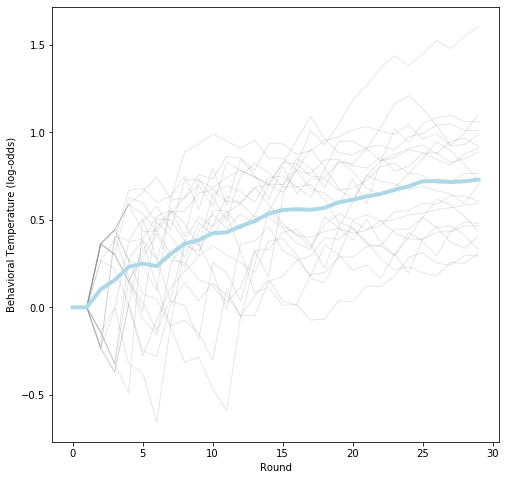

In [28]:


# volatility
group.plot_history("1-TOM", "2-TOM", agent=1, state="", fun=lambda x: x['internal_states']['opponent_states'][1]['own_states']['param_mean'][0, 0], ylab="Volalitity (log-odds)")
# 

# behav temp 
group.plot_history("1-TOM", "2-TOM", agent=1, state="", fun=lambda x: x['internal_states']['opponent_states'][1]['own_states']['param_mean'][0, 1], ylab="Behavioral Temperature (log-odds)")

# bias
# make a check for if dilution
# a_ = agent0 if agent==0 else agent1
# a = group.get_agent(a_)
# x = 2 if a.dilution is None else 3
# if a.bias is None:
#     raise ValueError(f"{a_} does not estimate it opponent's bias")
# group.plot_history("1-TOM", "2-TOM", agent=1, state="", fun=lambda x: x['internal_states']['opponent_states'][1]['own_states']['param_mean'][0, x], ylab="Bias")


# dilution
# make a check for if dilution
# a = group.get_agent("2-TOM")
# x = 3 if a.bias is None else 2
# if a.dilution is None:
#     raise ValueError(f"{a_} does not not estimate it opponent's dilution")
# group.plot_history("1-TOM", "2-TOM", agent=1, state="", fun=lambda x: x['internal_states']['opponent_states'][1]['own_states']['param_mean'][0, x], ylab="Dilution")

AttributeError: 'AgentGroup' object has no attribute 'plot_tom_volatility_estimate'

In [30]:
a = group.get_agent("2-TOM")
a.bias is None

False

In [31]:
group.plot_tom_op_estimate("1-TOM", "2-TOM", agent=1, estimate="volatility", level=1, plot="mean")
group.plot_tom_op_estimate("1-TOM", "2-TOM", agent=1, estimate="behav_temp", level=1, plot="mean")
group.plot_tom_op_estimate("1-TOM", "2-TOM", agent=1, estimate="bias", level=1, plot="mean")
group.plot_tom_op_estimate("1-TOM", "2-TOM", agent=1, estimate="volatility", level=1, plot="var")

UnboundLocalError: local variable 't_str' referenced before assignment

history_agent1 1


<Figure size 576x576 with 0 Axes>

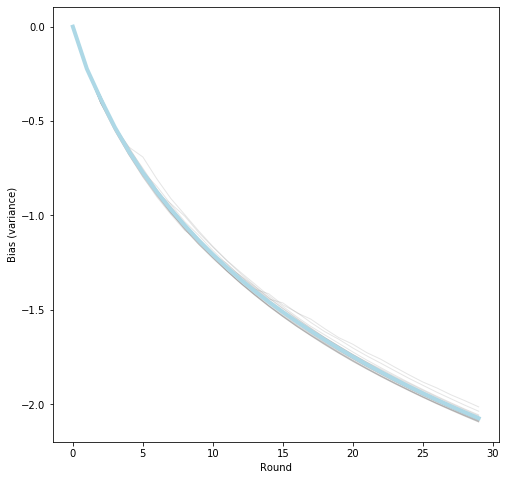

UnboundLocalError: local variable 't_str' referenced before assignment

In [32]:
group.plot_tom_op_estimate("1-TOM", "2-TOM", agent=1, estimate="bias", level=1, plot="var")
group.plot_tom_op_estimate("1-TOM", "2-TOM", agent=1, estimate="behav_temp", level=1, plot="var")